In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_220056/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-28 09:41:20.498043: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 09:41:20.531236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 09:41

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

In [4]:



X_truth=df_truth[X_labels]


#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)


X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]


Best model out of total max epochs found at epoch 182
Model 0.5 quantile saved...


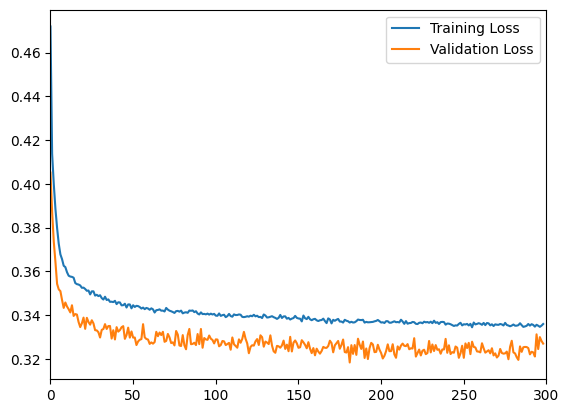

In [6]:
quantiles=np.array([0.1, 0.5, 0.9])
batch_size=500
save=True

nepochs=300
model=QuantileNetwork(quantiles=quantiles)

n_nodes=64
sequence=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes,n_nodes),
    nn.ReLU(),
    nn.Linear(n_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_no_quantile_correction/test_1',model=model,X_test=X_test,y_test=y_test)
    print("Model 0.5 quantile saved...")



## Load trained models and Visualise

In [7]:
#Load models
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_no_quantile_correction/test_1')


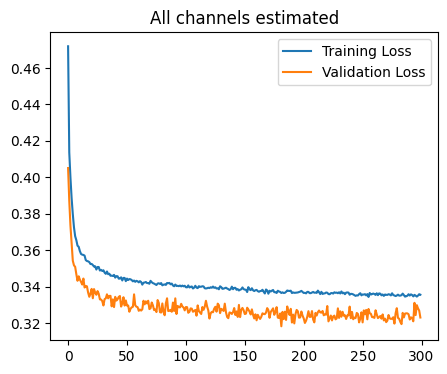

In [8]:
plt.rcParams["figure.figsize"] = [5, 4]

plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.title("All channels estimated")
plt.legend(['Training Loss','Validation Loss'])

In [9]:
cot_limit=True
cot_limit_val=100
if cot_limit:
    df_test=df.iloc[X_test.index]
    X_test=df_test[df_test['COT']<cot_limit_val][X_labels]
    indexes=X_test.index
    y_test=df.iloc[indexes][y_labels]

In [10]:
#Make predictions
y_preds=model.predict(X_test.to_numpy())
y_preds=y_preds[:,0,:]



In [11]:
## Calculate residuals
y=y_test.to_numpy()[:,0]
res=y-y_preds[:,1]

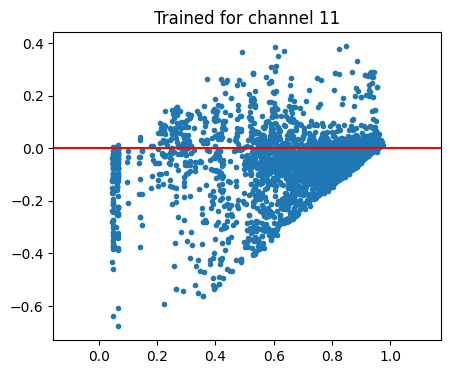

In [12]:
#Plot residuals

plt.plot(y,res,'.')
plt.title("Trained for channel 11")
plt.hlines(0,xmin=-1,xmax=10,colors='r')
plt.xlim((np.min(y)-0.2,np.max(y)+0.2))

plt.show()


In [13]:
r2=r2_score(y,y_preds[:,1])
mse=mean_squared_error(y,y_preds[:,1])

print("R2 score channel 11, model trained for channel 11: "+str(r2))
print(" ")
print("MSE score channel 11, model trained for channel 11: "+str(mse))


R2 score channel 11, model trained for channel 11: 0.8021865292763187
 
MSE score channel 11, model trained for channel 11: 0.007297195741725684


In [14]:
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds)

print("Quantile rate, model trained for channel 11: "+str(quant_rate))

Quantile rate, model trained for channel 11: [0.0732     0.4812     0.95106667]
